In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures

# Part 2d

In [3]:
# part i: Converting each each catorgoical feature into scalar encoding
file_path = os.path.expanduser('~/Documents/GitHub/ee219/Project 4/network_backup_dataset.csv')

df = pd.read_csv(file_path)
df.drop('Backup Time (hour)', axis = 1) # We do not use backup time in prediction

# Changing weekdays strings to scaler
def days_to_num(day_of_week):
    days_to_num_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    
    num = []
    for i in xrange(0, len(day_of_week)):
        num.append(days_to_num_map[day_of_week[i]])
    return num

# Changing the file names or workflow ids to scalar
def underscore_str_to_num(str_array):
    num = []
    for i in xrange(0,len(str_array)):
        val = [int(s) for s in str_array[i].split('_') if s.isdigit()]
        num.append(val[0]) ## We do this so we get a scalar not an array of 1
    return num
    
df['Day of Week'] = days_to_num(df['Day of Week'])
df['Work-Flow-ID'] = underscore_str_to_num(df['Work-Flow-ID'])
df['File Name'] = underscore_str_to_num(df['File Name'])

In [4]:
# Defining features and target to be used 
x = ['Week #','Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID','File Name']
y = ['Size of Backup (GB)']

features = df.loc[ : , lambda df : x].as_matrix()
target = df.loc[ : , lambda df : y].as_matrix().ravel()

In [5]:
# Input: 
#       - estimator: to fit and predict 
#       - features: needs to be in numpy array
#       - target: needs to be in numpy array

# Outputs:
#       - training RMSE
#       - Testing RMSE

def ten_folds(estimator, features, target):
    kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
    
    sum_MSE_train = 0
    sum_MSE_test = 0
    
    for trainIndex, testIndex in kf.split(features):
        # Setting up training data
        x_trainSet = features[trainIndex]
        y_trainSet = target[trainIndex]
        
        # Set up testing data
        x_testSet = features[testIndex]
        y_testSet = target[testIndex]
        
        # Train model using training sets
        estimator.fit(x_trainSet, y_trainSet)
        
        # Make predictions using training/testing set
        y_pred_train = estimator.predict(x_trainSet)
        y_pred_test = estimator.predict(x_testSet)
        
        # Sum all MSE
        sum_MSE_train = sum_MSE_train + mean_squared_error(y_trainSet, y_pred_train)
        sum_MSE_test = sum_MSE_test + mean_squared_error(y_testSet, y_pred_test)
        
    RMSE_train = sqrt(sum_MSE_train/10)
    RMSE_test = sqrt(sum_MSE_train/10)
    return RMSE_train, RMSE_test

In [6]:
# Plotting all graphs: 
def plot_fitted_residual(predicted, actual):
    #Plot graph as Fitted vs Actual
    plt.figure()
    plt.scatter(x=actual, y=predicted, edgecolors=(0, 0, 0))
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Fitted')

    #Plot graph as Value vs Index
    plt.figure(figsize=((30,20)))
    plt.grid(True)
    p1 = plt.scatter(y=actual, x=range(0,len(actual)), color= 'blue')
    p2 = plt.scatter(y=predicted, x=range(0,len(actual)), color = 'red')
    plt.legend((p1, p2), ('Actual', 'Predicted'), fontsize = 'xx-large')
    plt.xlabel('Index')
    plt.ylabel('Fitted and Actual') 
    
    # Plot the residual
    residual = actual - predicted
    plt.figure()
    plt.xticks(rotation='vertical')
    plt.scatter(x=residual, y=predicted, edgecolors=(0, 0, 0))
    plt.xlabel('Residual')
    plt.ylabel('Fitted')
    plt.xlim((min(residual) - 0.05, max(residual) +0.05))

## Section 2.d.i

Running  0
Training RMSE: 0.0358362959992
Test RMSE: 0.0358362959992 

Running  1
Training RMSE: 0.148764159175
Test RMSE: 0.148764159175 

Running  2
Training RMSE: 0.0429136852757
Test RMSE: 0.0429136852757 

Running  3
Training RMSE: 0.00724432243424
Test RMSE: 0.00724432243424 

Running  4
Training RMSE: 0.0859177525088
Test RMSE: 0.0859177525088 



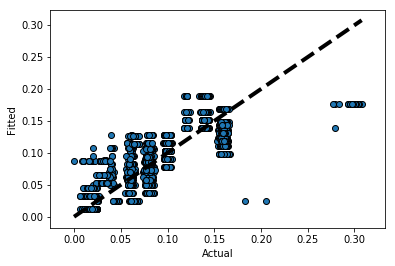

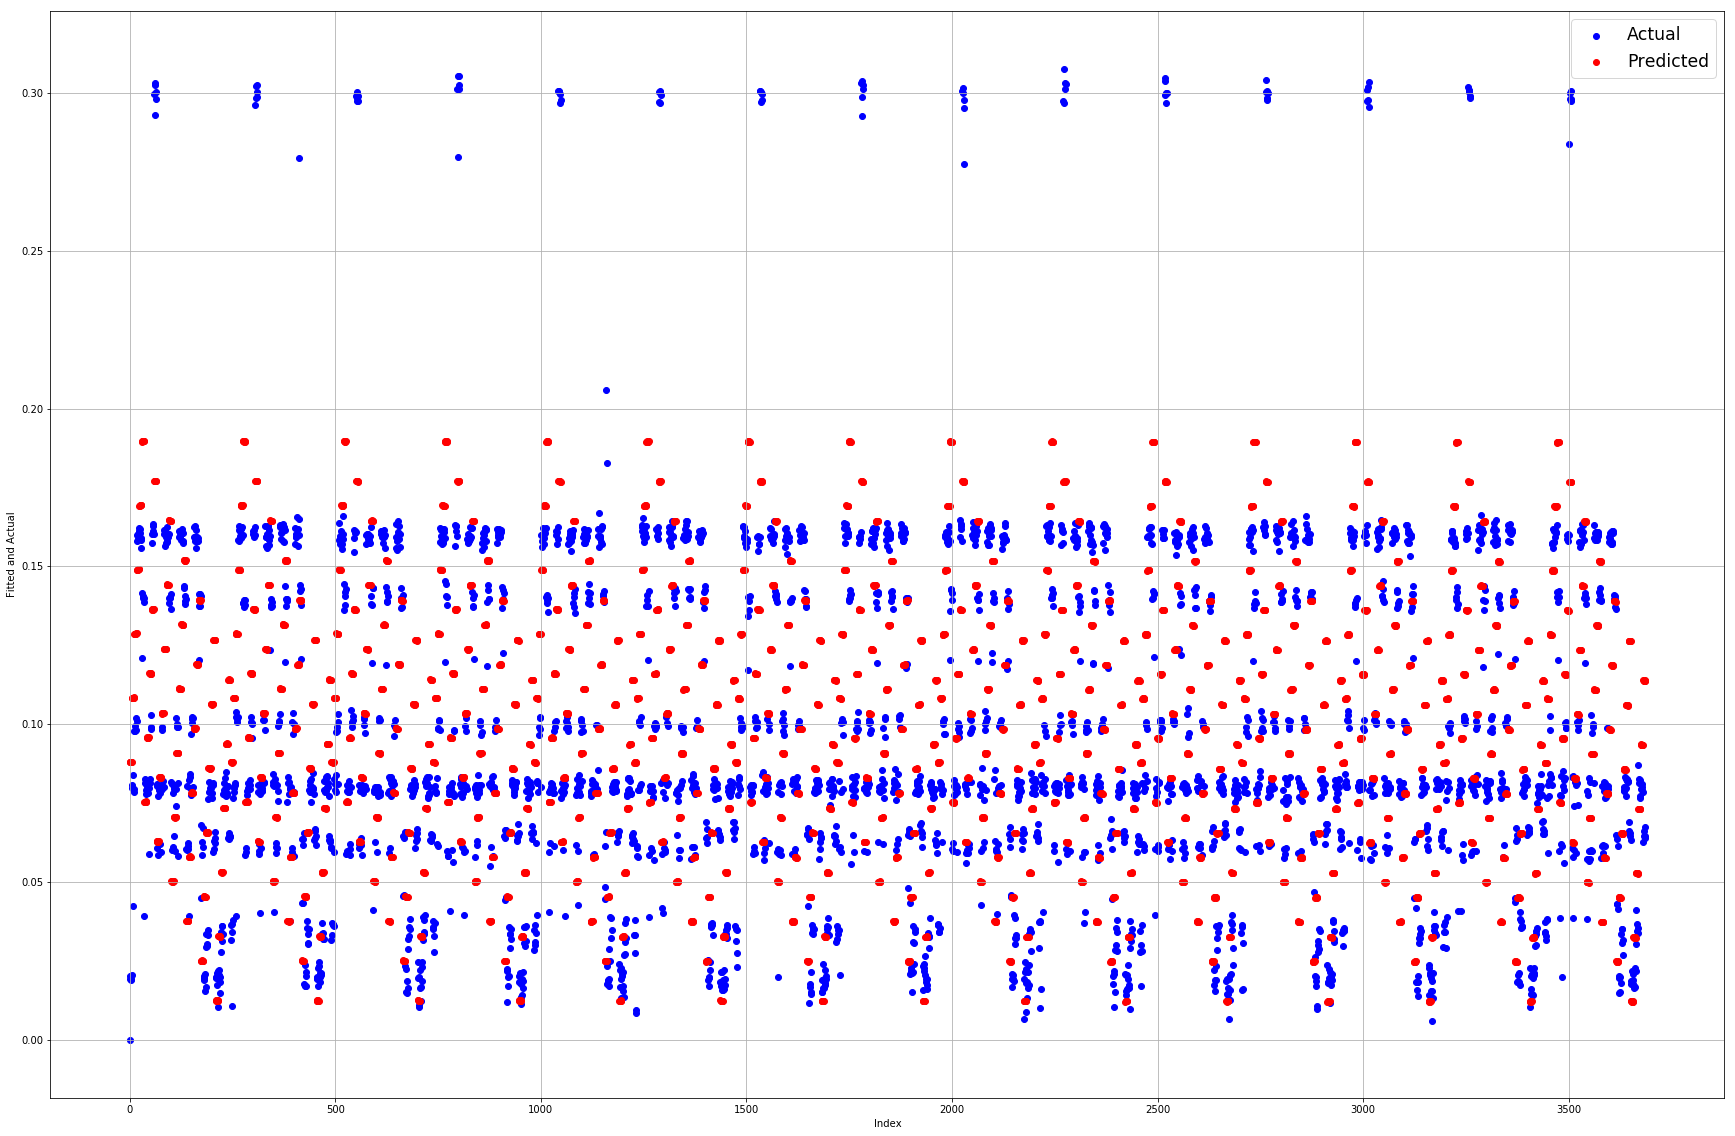

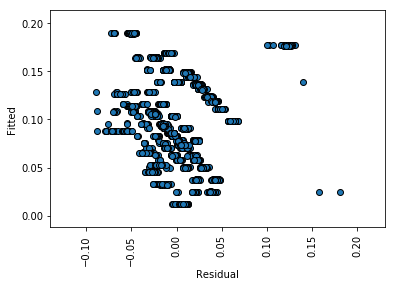

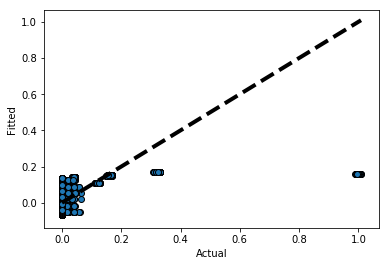

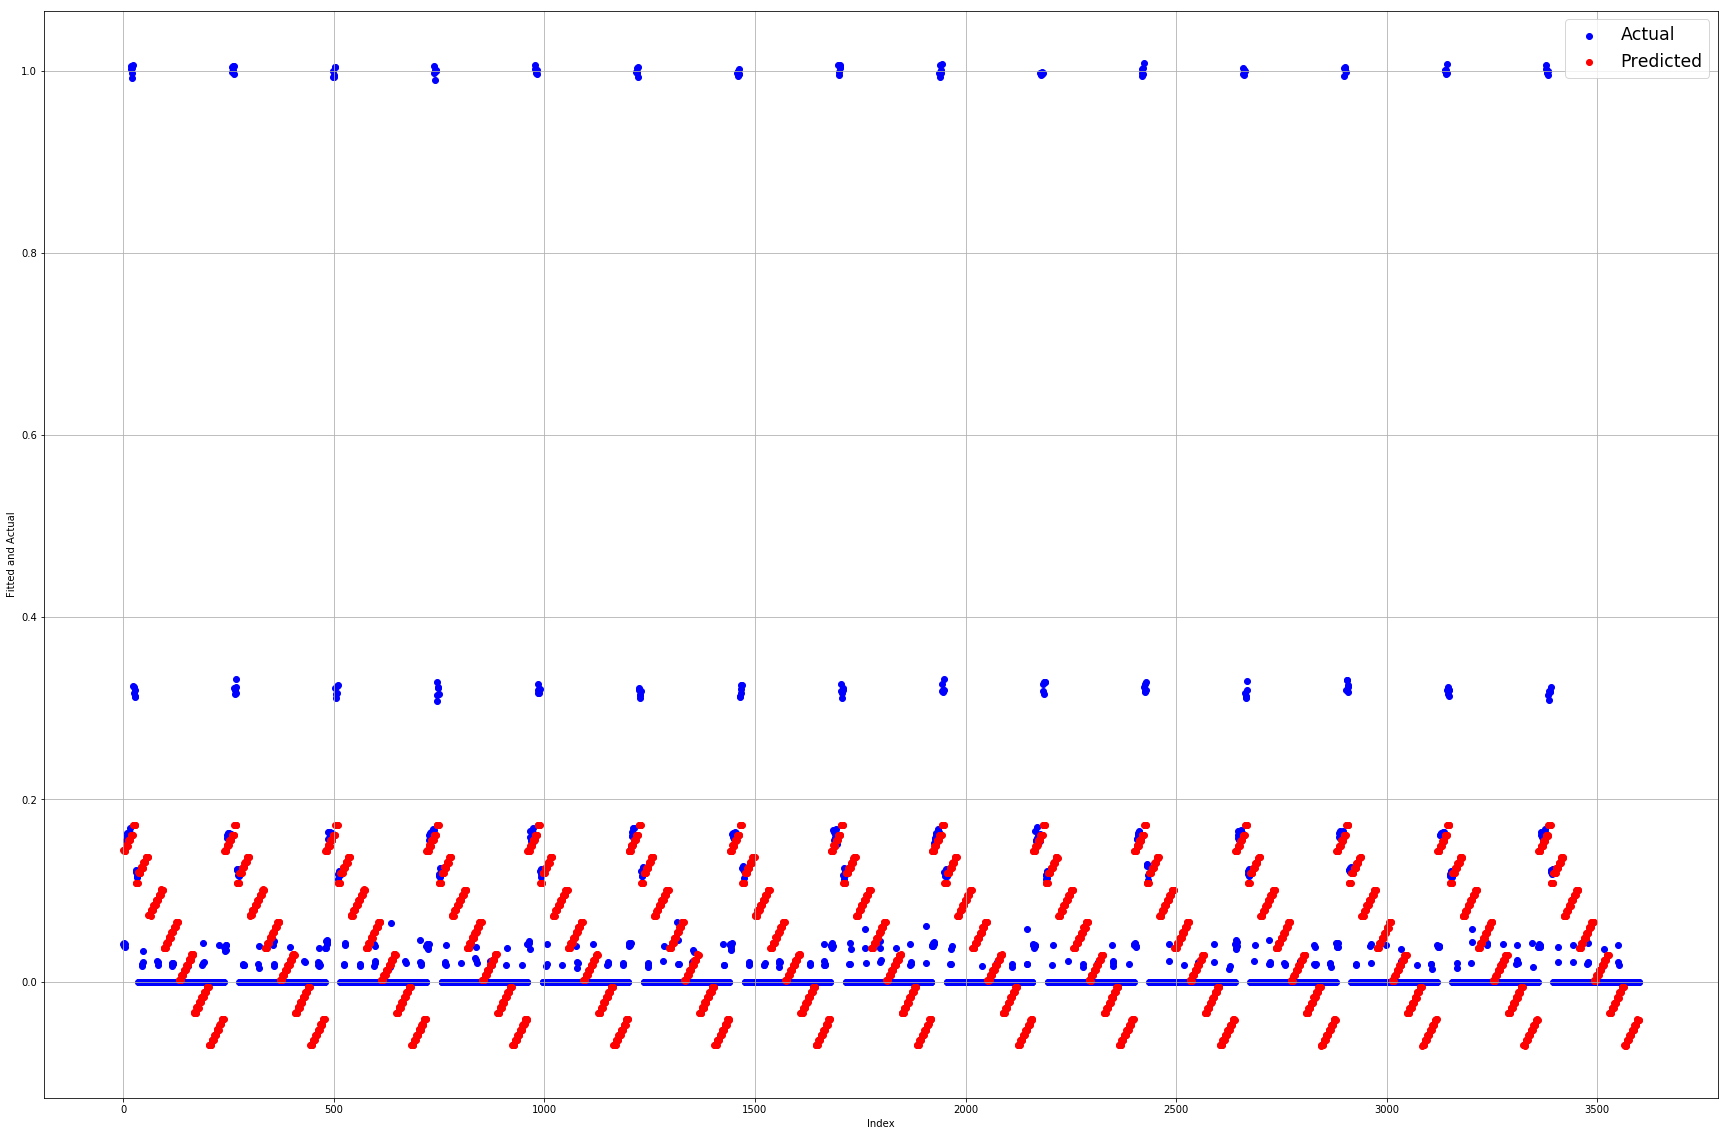

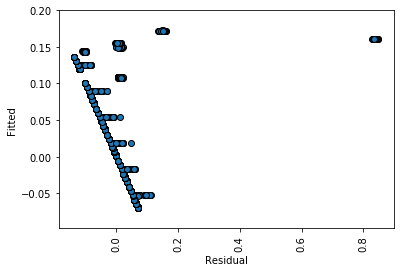

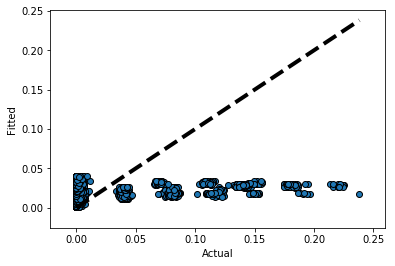

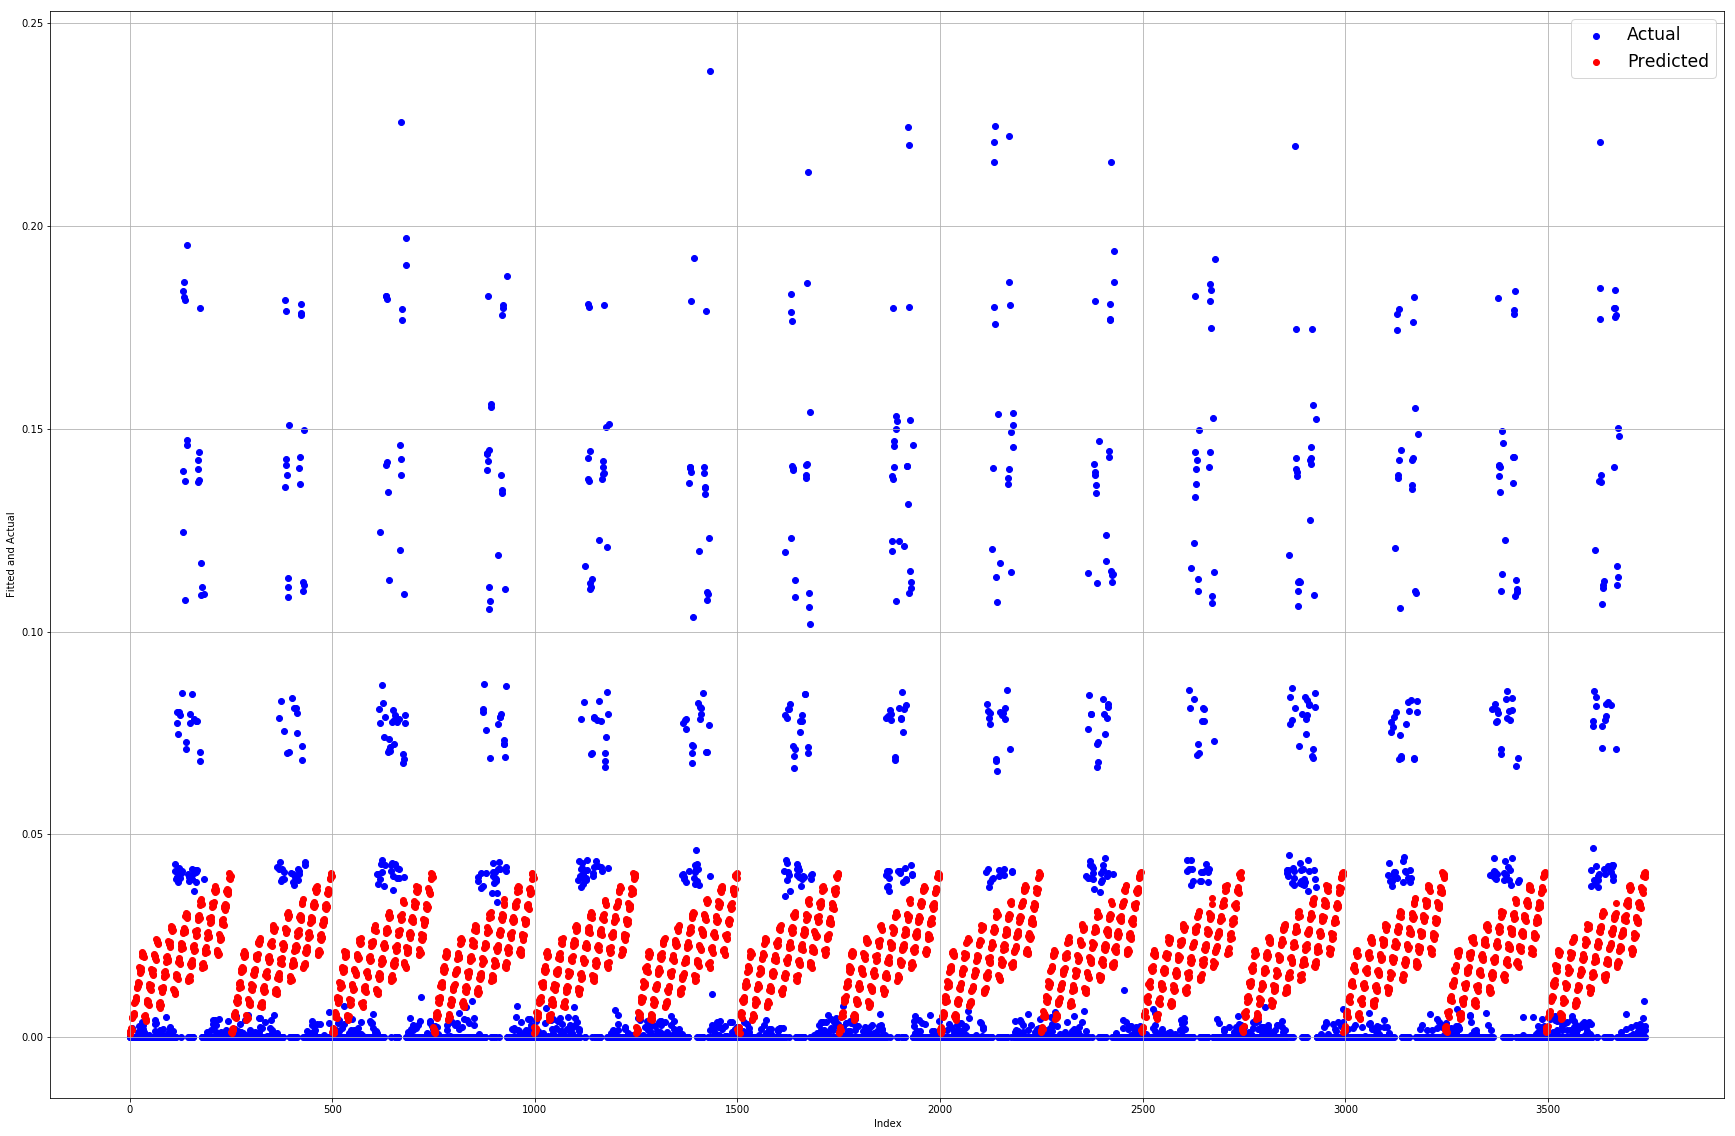

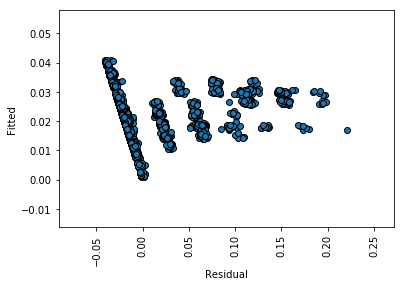

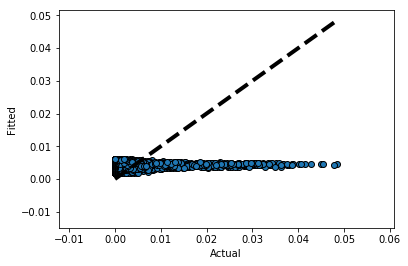

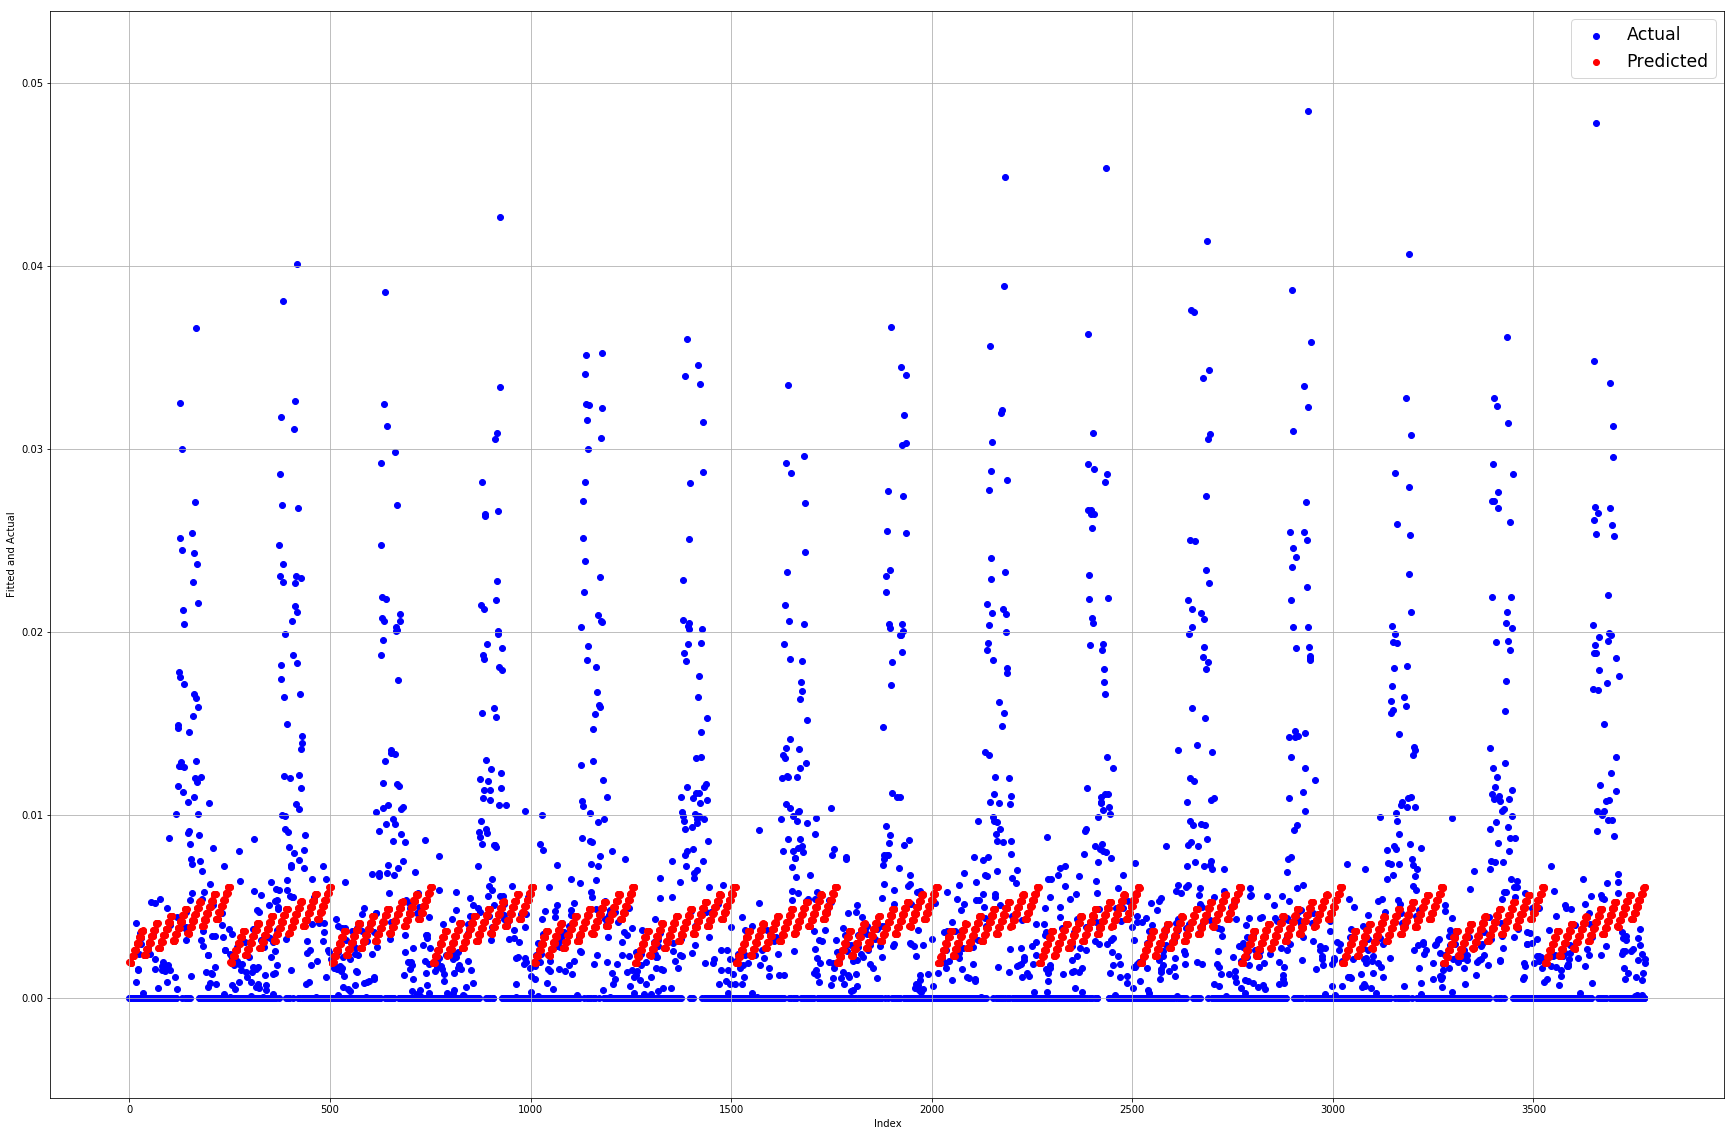

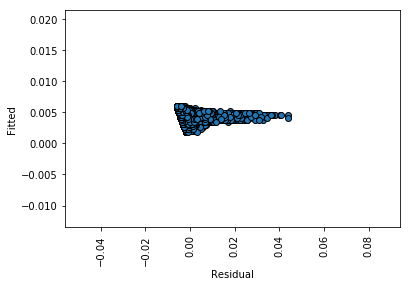

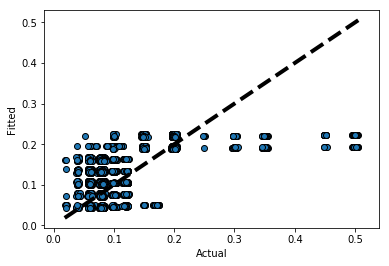

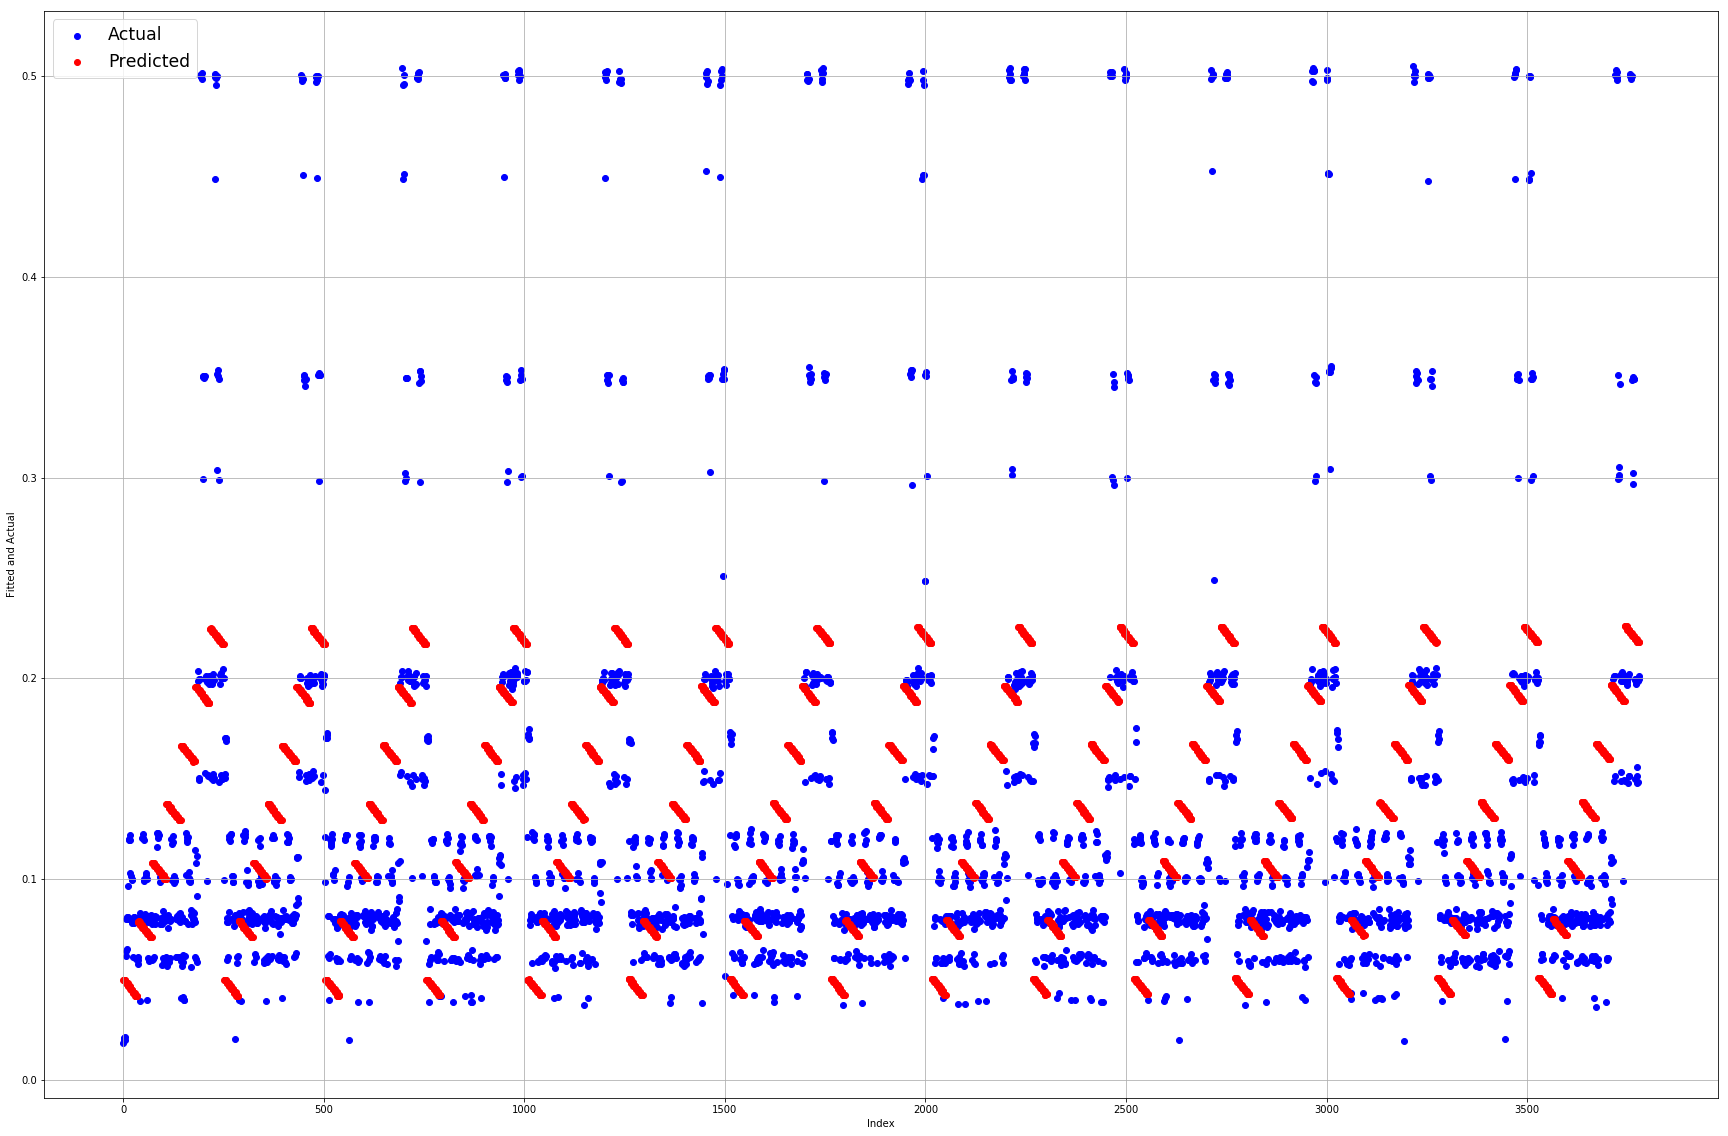

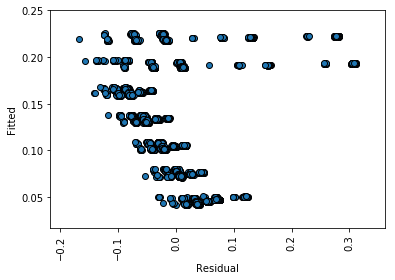

In [13]:
# Plotting different wfID
linReg = LinearRegression(normalize = True)
for wfID, wfGrouped in df.groupby('Work-Flow-ID'):
    print 'Running ', wfID
#     print wfGrouped
    features_grouped = wfGrouped.loc[ : , lambda df : x].as_matrix()
    target_grouped = wfGrouped.loc[ : , lambda df : y].as_matrix().ravel()
    
    # Calculating the RMSE accross ten folds cross validation
    rmseTrain, rmseTest = ten_folds(linReg, features_grouped, target_grouped)
    print 'Training RMSE:', rmseTrain
    print 'Test RMSE:', rmseTest, '\n'
    
    # Plotting
    linReg.fit(features_grouped, target_grouped)
    predicted = linReg.predict(features_grouped)
    plot_fitted_residual(predicted, target_grouped)
    

Running  0
Training RMSE: 0.0358362959992
Test RMSE: 0.0358362959992 

Running  1
Training RMSE: 0.148764159175
Test RMSE: 0.148764159175 

Running  2
Training RMSE: 0.0429136852757
Test RMSE: 0.0429136852757 

Running  3
Training RMSE: 0.00724432243424
Test RMSE: 0.00724432243424 

Running  4
Training RMSE: 0.0859177525088
Test RMSE: 0.0859177525088 



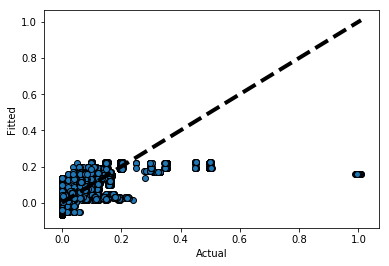

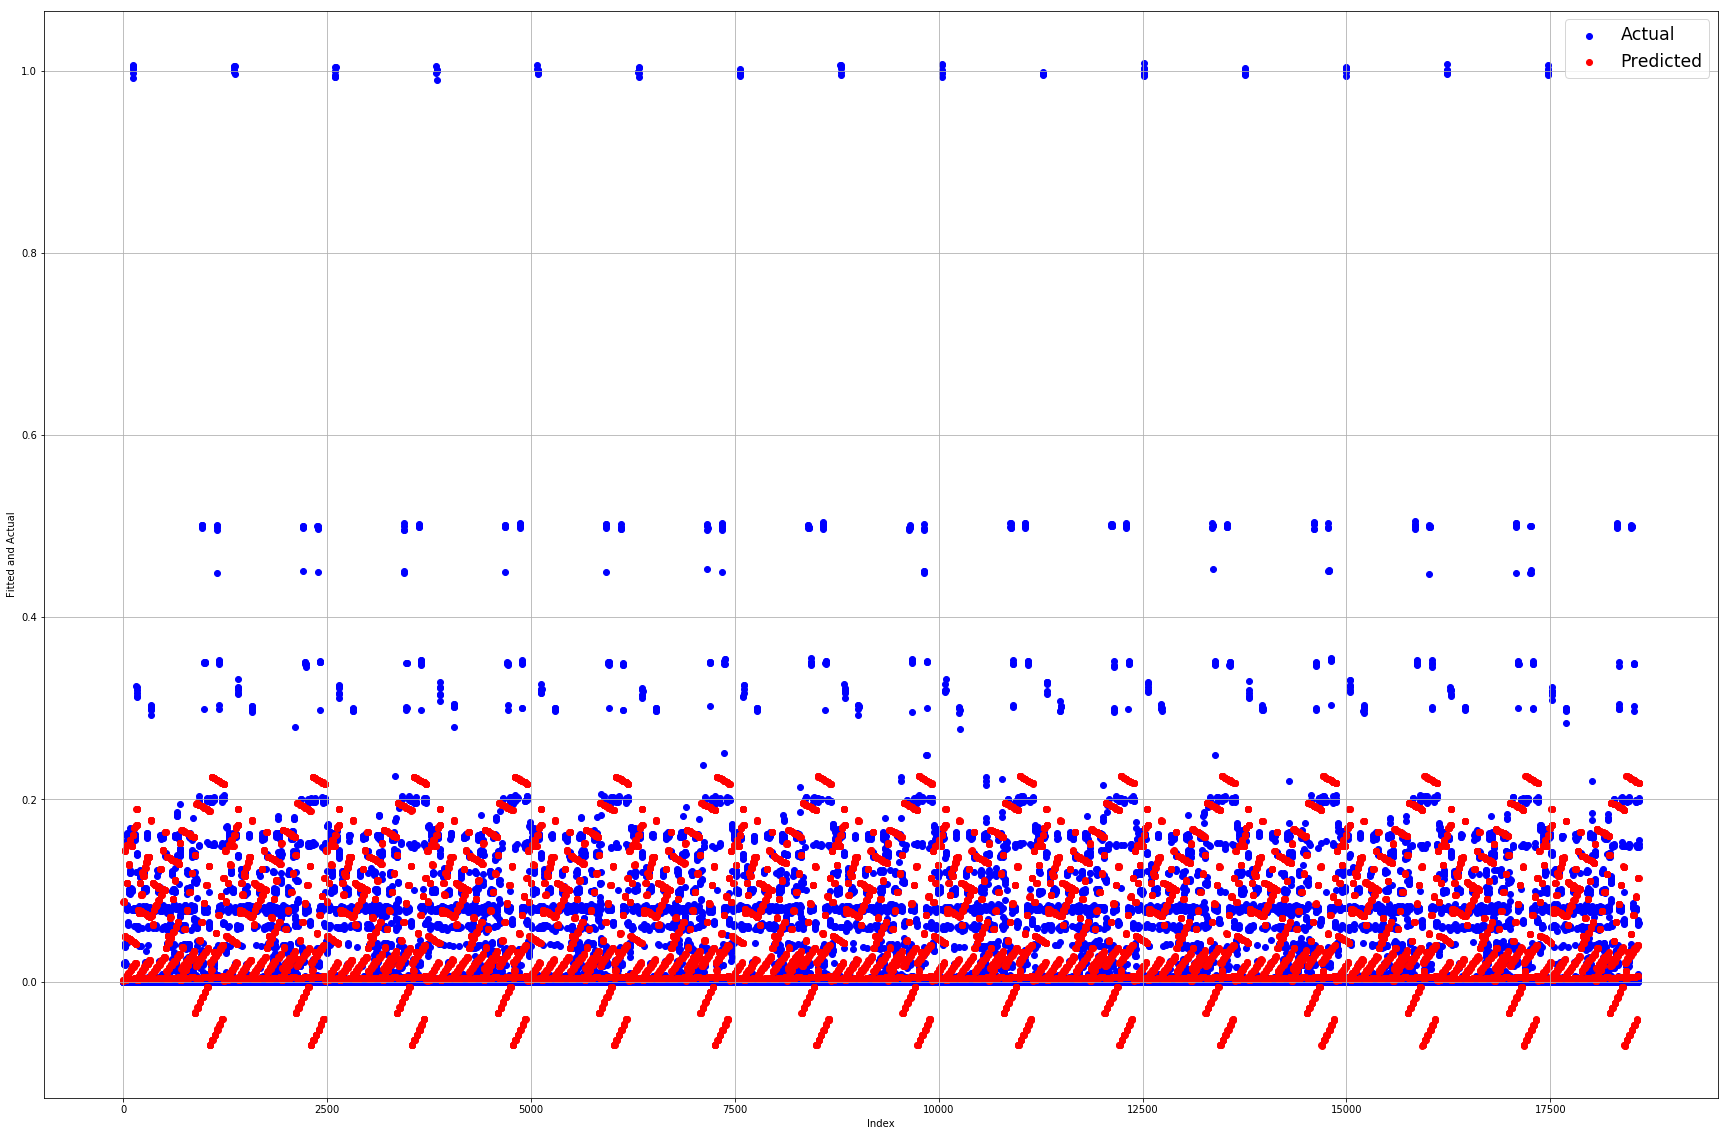

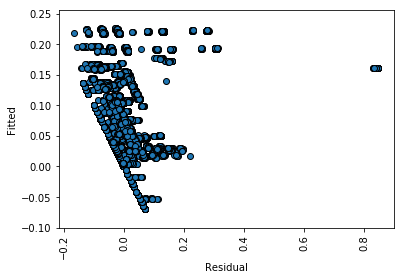

In [22]:
# Plotting overall
predicted_overall = np.zeros(len(df))

linReg = LinearRegression(normalize = True)
for wfID, wfGrouped in df.groupby('Work-Flow-ID'):
    print 'Running ', wfID
    
    features_grouped = wfGrouped.loc[ : , lambda df : x].as_matrix()
    target_grouped = wfGrouped.loc[ : , lambda df : y].as_matrix().ravel()
    
    # Calculating the RMSE accross ten folds cross validation
    rmseTrain, rmseTest = ten_folds(linReg, features_grouped, target_grouped)
    print 'Training RMSE:', rmseTrain
    print 'Test RMSE:', rmseTest, '\n'

    # Plotting
    linReg.fit(features_grouped, target_grouped)
    predicted[wfGrouped.index] = linReg.predict(features_grouped)
plot_fitted_residual(predicted, target)
    

## Section 2.d.ii

Running  0
Minimum Training RMSE is  0.00696487374985  at degree  11
Minimum Testing RMSE is  0.00696487374985  a degree  11
Running  1
Minimum Training RMSE is  0.00537757940244  at degree  11
Minimum Testing RMSE is  0.00537757940244  a degree  11
Running  2
Minimum Training RMSE is  0.0188153155297  at degree  9
Minimum Testing RMSE is  0.0188153155297  a degree  9
Running  3
Minimum Training RMSE is  0.00431153995396  at degree  8
Minimum Testing RMSE is  0.00431153995396  a degree  8
Running  4
Minimum Training RMSE is  0.0229991215865  at degree  11
Minimum Testing RMSE is  0.0229991215865  a degree  11


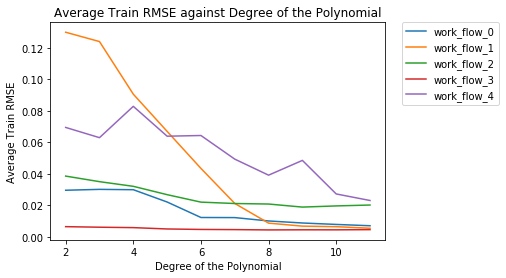

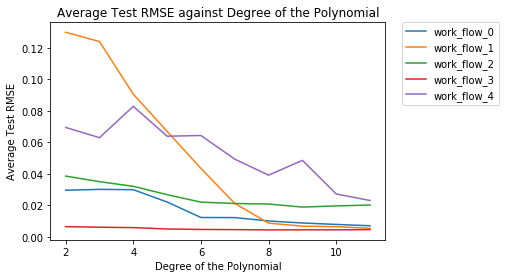

In [19]:
linReg = LinearRegression(normalize = True)

    
for wfID, wfGrouped in df.groupby('Work-Flow-ID'):
    print 'Running ', wfID
    RMSE_Train = []
    RMSE_Test = []
    
    for degree in xrange(2, 12, 1):
        # Extracting the features from grouping
        features_grouped = wfGrouped.loc[ : , lambda df : x].as_matrix()
        target_grouped = wfGrouped.loc[ : , lambda df : y].as_matrix().ravel()

        # Changing the features to polynomial
        pf = PolynomialFeatures(degree = degree)
        pf.fit(features_grouped)
        poly_features = pf.transform(features_grouped)


        # Calculating the RMSE accross ten folds cross validation
        rmseTrain, rmseTest = ten_folds(linReg, poly_features, target_grouped)
        RMSE_Train.append(rmseTrain)
        RMSE_Test.append(rmseTest)
    
    print 'Minimum Training RMSE is ', min(RMSE_Train), ' at degree ', (RMSE_Train.index(min(RMSE_Train)) + 2)
    print 'Minimum Testing RMSE is ', min(RMSE_Test), ' a degree ', (RMSE_Test.index(min(RMSE_Test)) + 2)
    
    plt.figure(1)
    plt.title('Average Train RMSE against Degree of the Polynomial')
    plt.xlabel("Degree of the Polynomial")
    plt.ylabel('Average Train RMSE')
    plt.plot(range(2,12,1), RMSE_Train, label='work_flow_'+str(wfID))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.figure(2)
    plt.title('Average Test RMSE against Degree of the Polynomial')
    plt.xlabel("Degree of the Polynomial")
    plt.ylabel('Average Test RMSE')
    plt.plot(range(2,12,1), RMSE_Test, label='work_flow_'+str(wfID))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
 

Running  0
Minimum Training RMSE is  0.00696487374985  at degree  11
Minimum Testing RMSE is  0.00696487374985  a degree  11
Running  1
Minimum Training RMSE is  0.00537757940244  at degree  11
Minimum Testing RMSE is  0.00537757940244  a degree  11
Running  2
Minimum Training RMSE is  0.0188153155297  at degree  9
Minimum Testing RMSE is  0.0188153155297  a degree  9
Running  3
Minimum Training RMSE is  0.00431153995396  at degree  8
Minimum Testing RMSE is  0.00431153995396  a degree  8
Running  4
Minimum Training RMSE is  0.0229991215865  at degree  11
Minimum Testing RMSE is  0.0229991215865  a degree  11


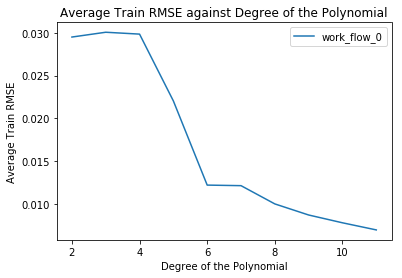

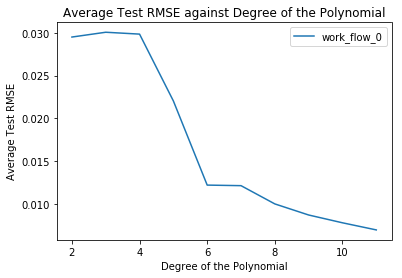

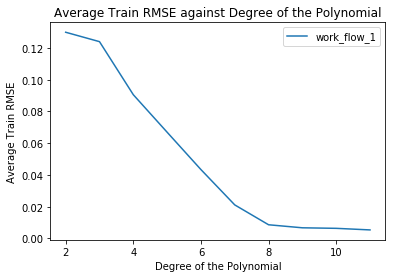

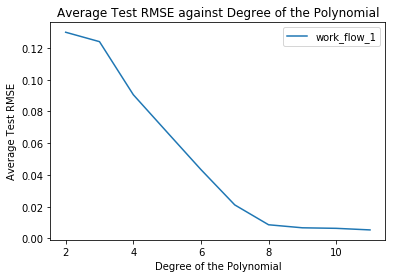

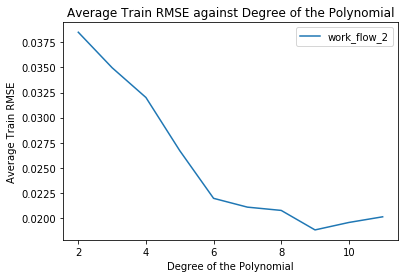

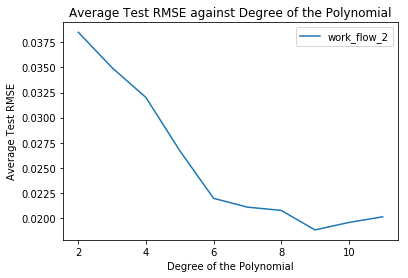

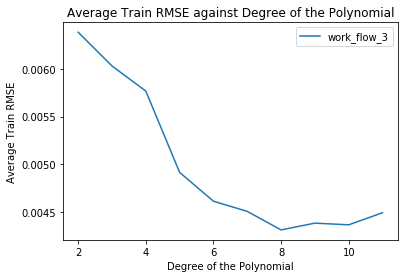

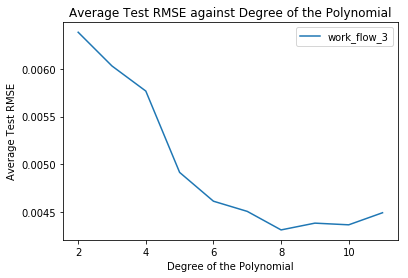

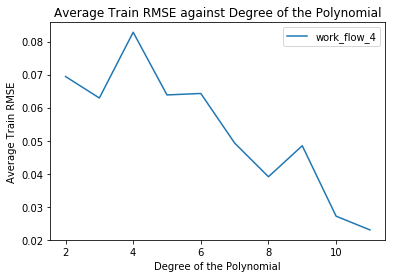

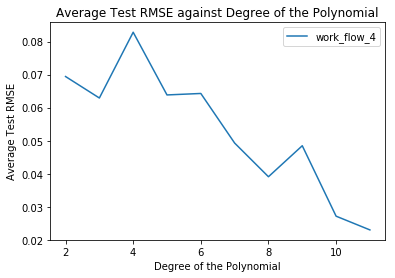

In [26]:
linReg = LinearRegression(normalize = True)

    
for wfID, wfGrouped in df.groupby('Work-Flow-ID'):
    print 'Running ', wfID
    RMSE_Train = []
    RMSE_Test = []
    
    for degree in xrange(2, 12, 1):
        # Extracting the features from grouping
        features_grouped = wfGrouped.loc[ : , lambda df : x].as_matrix()
        target_grouped = wfGrouped.loc[ : , lambda df : y].as_matrix().ravel()

        # Changing the features to polynomial
        pf = PolynomialFeatures(degree = degree)
        pf.fit(features_grouped)
        poly_features = pf.transform(features_grouped)


        # Calculating the RMSE accross ten folds cross validation
        rmseTrain, rmseTest = ten_folds(linReg, poly_features, target_grouped)
        RMSE_Train.append(rmseTrain)
        RMSE_Test.append(rmseTest)
    
    print 'Minimum Training RMSE is ', min(RMSE_Train), ' at degree ', (RMSE_Train.index(min(RMSE_Train)) + 2)
    print 'Minimum Testing RMSE is ', min(RMSE_Test), ' a degree ', (RMSE_Test.index(min(RMSE_Test)) + 2)
    
    plt.figure()
    plt.title('Average Train RMSE against Degree of the Polynomial')
    plt.xlabel("Degree of the Polynomial")
    plt.ylabel('Average Train RMSE')
    plt.plot(range(2,12,1), RMSE_Train, label='work_flow_'+str(wfID))
    plt.legend()
    
    plt.figure()
    plt.title('Average Test RMSE against Degree of the Polynomial')
    plt.xlabel("Degree of the Polynomial")
    plt.ylabel('Average Test RMSE')
    plt.plot(range(2,12,1), RMSE_Test, label='work_flow_'+str(wfID))
    plt.legend()
 

Running  0
Training RMSE: 0.00696487374985
Test RMSE: 0.00696487374985 

Running  1
Training RMSE: 0.00537757940244
Test RMSE: 0.00537757940244 

Running  2
Training RMSE: 0.0188153155297
Test RMSE: 0.0188153155297 

Running  3
Training RMSE: 0.00431153995396
Test RMSE: 0.00431153995396 

Running  4
Training RMSE: 0.0229991215865
Test RMSE: 0.0229991215865 



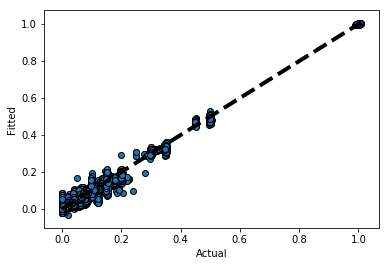

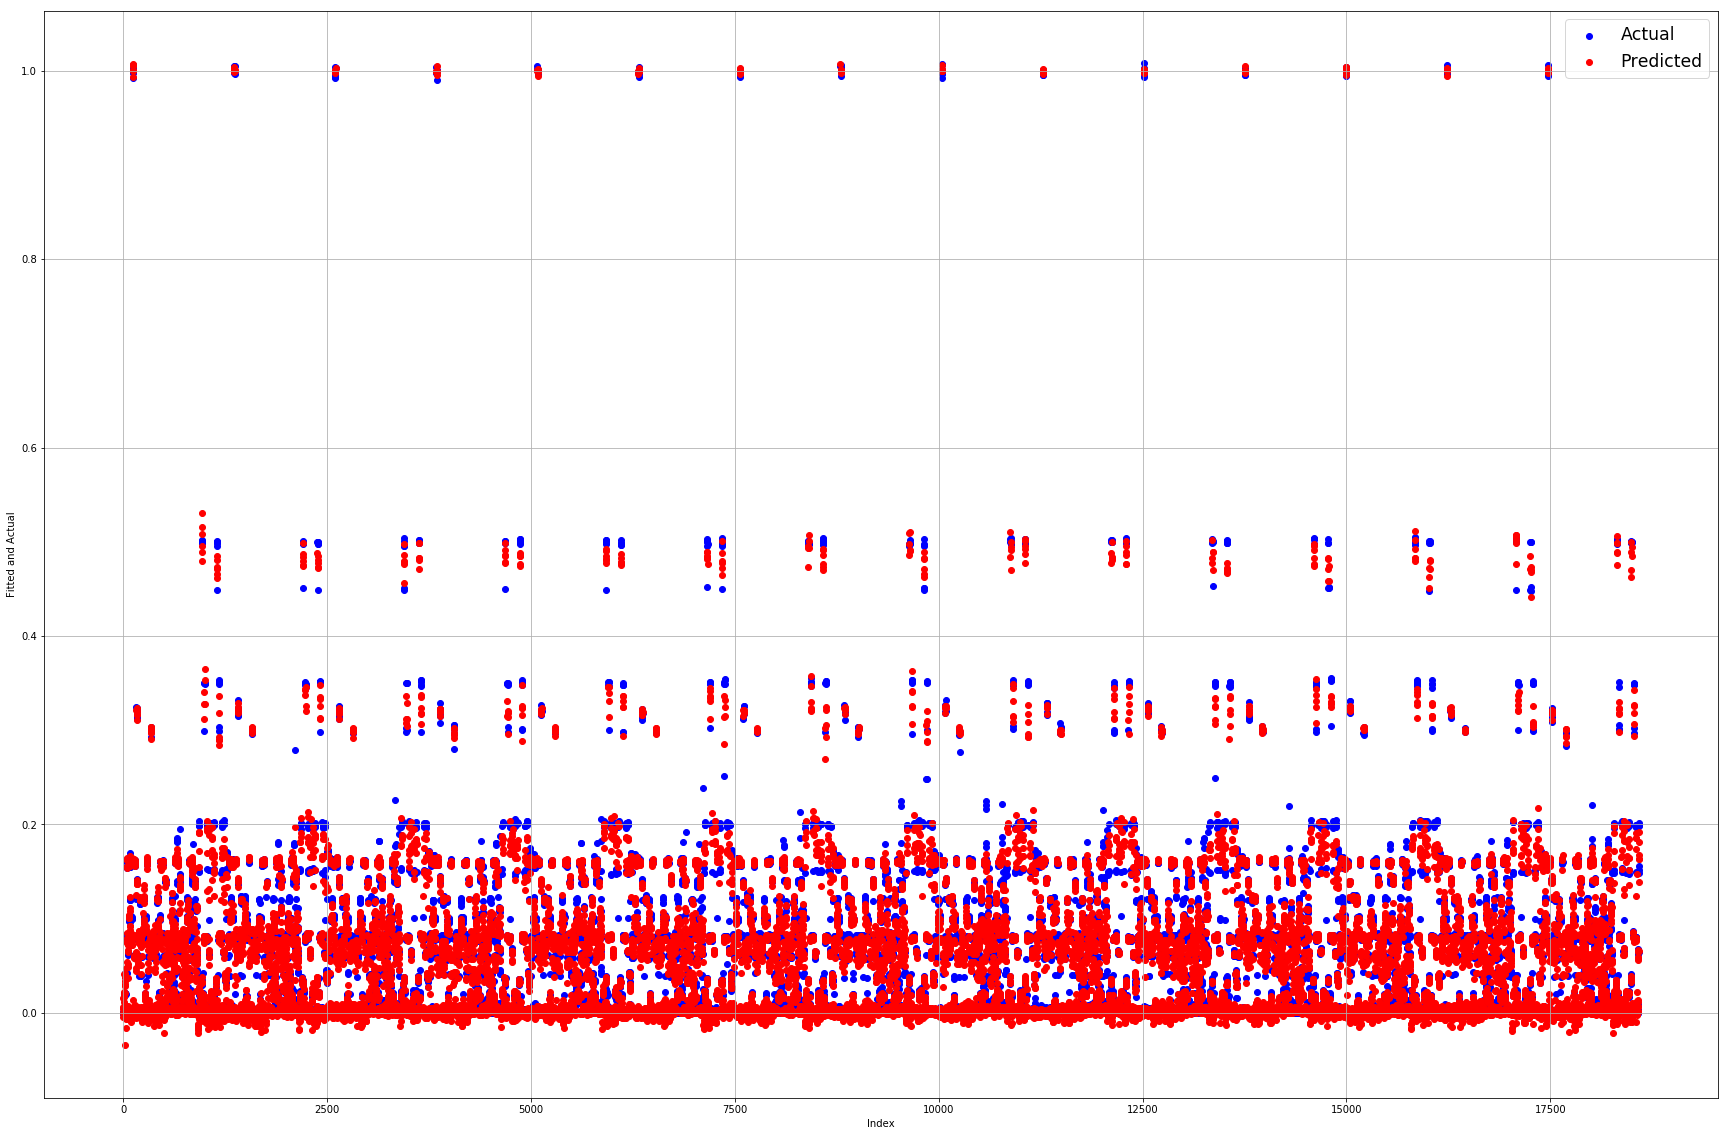

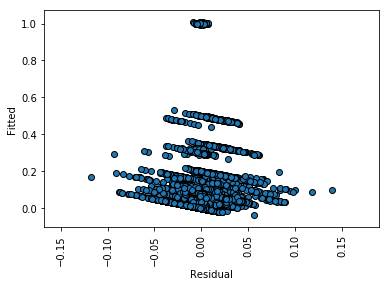

In [27]:
# Plotting overall
predicted_overall = np.zeros(len(df))

poly_degree = [11,11,9,8,11] # Best degree according to work-flow

linReg = LinearRegression(normalize = True)
for wfID, wfGrouped in df.groupby('Work-Flow-ID'):
    print 'Running ', wfID
    
    features_grouped = wfGrouped.loc[ : , lambda df : x].as_matrix()
    target_grouped = wfGrouped.loc[ : , lambda df : y].as_matrix().ravel()
    
    # Changing the features to polynomial
    pf = PolynomialFeatures(degree = poly_degree[wfID])
    pf.fit(features_grouped)
    poly_features = pf.transform(features_grouped)
    
    # Calculating the RMSE accross ten folds cross validation
    rmseTrain, rmseTest = ten_folds(linReg, poly_features, target_grouped)
    print 'Training RMSE:', rmseTrain
    print 'Test RMSE:', rmseTest, '\n'

    # Plotting
    linReg.fit(poly_features, target_grouped)
    predicted[wfGrouped.index] = linReg.predict(poly_features)
plot_fitted_residual(predicted, target)
    